# **Project Name**    -  Hotel Recommendation



##### **Project Type**    - Recommendation
##### **Contribution**    - Individual
##### **Team Member 1 -** - Aparna Praturi


# **Project Summary -**

In this project, we recommend hotels to a user in their desired located using collaborative filtering. We rank hotels based on weighted scores by similar users and recommend the top hotel in the required destination. The major steps of this approach are

1. Build user-hotel matrix.
2. Build user fetaures matrix.
3. Determine the most similar users for a given user by calculating the cosine similarity scores with user features.
4. Calculate weighted average scores of hotels based on preferences of  most similar users and determine list of recommended hotels.
5. From the sorted list of recommended hotels, choose the first hotel which is in the required destination.

The user features used in the project to determine similarity are age, gender and price quartile.

As there is no data of user ratings, the number of days stayed in a hotel is assumed to be an indicator of preference.

This recommender system gives a suitable hotel recommendation in the desired location.

The streamlit app for this recommender system is available in the github repository.

# **GitHub Link -**

https://github.com/Aparna-Praturi/Flight-price-prediction

# **Problem Statement**


**Build a recommendation system to recommend hotels based on user preferences and historical data.**

## ***1. Know The Data***

### Import Libraries

In [1]:
# Import Libraries
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from google.colab import drive
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics.pairwise import cosine_similarity

from nltk import bigrams, trigrams

import joblib




### Dataset Loading

In [3]:
# mount drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load users data
path1 ='/content/drive/MyDrive/Data science/Datasets/travel_capstone/users.csv'
df_users = pd.read_csv(path1)

In [5]:
# load hotels data
path2 ='/content/drive/MyDrive/Data science/Datasets/travel_capstone/hotels.csv'
df_hotels = pd.read_csv(path2)

### Dataset First View

In [6]:
# Hotels data view
df_hotels.head()

,travelCode,userCode,name,place,days,price,total,date
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019


In [7]:
# users data view
df_users.head()

,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44


### Dataset Rows & Columns count

In [8]:
# hotels data shape
df_hotels.shape

(40552, 8)

In [9]:
# Users data shape
df_users.shape

(1340, 5)

### Dataset Information

In [10]:
# hotels data info
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   travelCode  40552 non-null  int64  
 1   userCode    40552 non-null  int64  
 2   name        40552 non-null  object 
 3   place       40552 non-null  object 
 4   days        40552 non-null  int64  
 5   price       40552 non-null  float64
 6   total       40552 non-null  float64
 7   date        40552 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.5+ MB


In [11]:
# users data info
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   code     1340 non-null   int64 
 1   company  1340 non-null   object
 2   name     1340 non-null   object
 3   gender   1340 non-null   object
 4   age      1340 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 52.5+ KB


#### Duplicate Values

In [12]:
# finding duplicates for hotels data

df_hotels.duplicated().sum()

0

In [13]:
# finding duplicates forusers data

df_users.duplicated().sum()

0

#### Missing Values/Null Values

In [14]:
# Missing Values in hotel data
df_hotels.isna().sum()

,0
travelCode,0
userCode,0
name,0
place,0
days,0
price,0
total,0
date,0


In [15]:
# Missing data in users data
df_users.isna().sum()

,0
code,0
company,0
name,0
gender,0
age,0


### What did you know about your dataset?

1. The users data set has 1340 rows and 5 columns with no missing values and no duplicates.

2. The hotels dataset has 40552 rows and 8 columns with no missing values and no duplicates.

## ***2. Understanding The Variables***

#### Check Unique Values for each variable.

In [16]:
# unique variables in users dataset
[{i:df_users[i].nunique()} for i in df_users.columns]

[{'code': 1340}, {'company': 5}, {'name': 1338}, {'gender': 3}, {'age': 45}]

In [17]:
# unique variables in hotels dataset
[{i:df_hotels[i].nunique()} for i in df_hotels.columns]

[{'travelCode': 40552},
 {'userCode': 1310},
 {'name': 9},
 {'place': 9},
 {'days': 4},
 {'price': 9},
 {'total': 36},
 {'date': 199}]

##  ***3.Data Wrangling***

In [18]:
# Renaming columns in hotels data
df_hotels1 = df_hotels.copy()
df_hotels1.rename(columns = {'name':'hotelName'}, inplace = True)

In [19]:
# Retaining only relavant columns from users data
df_users1 = df_users[['code','gender', 'age']]

In [20]:
# Renaming columns in modified users dataset
df_users1 = df_users1.copy()
df_users1.rename(columns = {'code':'userCode'}, inplace = True)

In [21]:
df_users1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userCode  1340 non-null   int64 
 1   gender    1340 non-null   object
 2   age       1340 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 31.5+ KB


In [22]:
df_hotels1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   travelCode  40552 non-null  int64  
 1   userCode    40552 non-null  int64  
 2   hotelName   40552 non-null  object 
 3   place       40552 non-null  object 
 4   days        40552 non-null  int64  
 5   price       40552 non-null  float64
 6   total       40552 non-null  float64
 7   date        40552 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.5+ MB


###  Merging the datasets

In [23]:
# join df_hotels and df_users1

df = pd.merge(df_hotels1, df_users1, on='userCode', how = 'inner')


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   travelCode  40552 non-null  int64  
 1   userCode    40552 non-null  int64  
 2   hotelName   40552 non-null  object 
 3   place       40552 non-null  object 
 4   days        40552 non-null  int64  
 5   price       40552 non-null  float64
 6   total       40552 non-null  float64
 7   date        40552 non-null  object 
 8   gender      40552 non-null  object 
 9   age         40552 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 3.1+ MB


In [25]:
df.head()

,travelCode,userCode,hotelName,place,days,price,total,date,gender,age
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019,male,21
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019,male,21
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019,male,21
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019,male,21
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019,male,21


In [26]:
df.tail()

,travelCode,userCode,hotelName,place,days,price,total,date,gender,age
40547,135938,1339,Hotel BP,Brasilia (DF),3,247.62,742.86,06/18/2020,male,35
40548,135939,1339,Hotel BP,Brasilia (DF),1,247.62,247.62,06/25/2020,male,35
40549,135940,1339,Hotel BW,Campo Grande (MS),3,60.39,181.17,07/02/2020,male,35
40550,135941,1339,Hotel BW,Campo Grande (MS),3,60.39,181.17,07/09/2020,male,35
40551,135942,1339,Hotel BD,Natal (RN),4,242.88,971.52,07/16/2020,male,35


In [27]:
# Dataset Columns

df.columns

Index(['travelCode', 'userCode', 'hotelName', 'place', 'days', 'price',
       'total', 'date', 'gender', 'age'],
      dtype='object')

In [28]:
# Dataset Describe

df.describe()

,travelCode,userCode,days,price,total,age
count,40552.000000,40552.000000,40552.000000,40552.000000,40552.000000,40552.000000
mean,67911.794461,666.963726,2.499679,214.439554,536.229513,42.790615
std,39408.199333,391.136794,1.119326,76.742305,319.331482,12.942656
min,0.000000,0.000000,1.000000,60.390000,60.390000,21.000000
25%,33696.750000,323.000000,1.000000,165.990000,247.620000,32.000000
50%,67831.000000,658.000000,2.000000,242.880000,495.240000,42.000000
75%,102211.250000,1013.000000,4.000000,263.410000,742.860000,54.000000
max,135942.000000,1339.000000,4.000000,313.020000,1252.080000,65.000000


In [29]:
# Check Unique Values for each variable.

[{i:df[i].nunique()} for i in df.columns]

[{'travelCode': 40552},
 {'userCode': 1310},
 {'hotelName': 9},
 {'place': 9},
 {'days': 4},
 {'price': 9},
 {'total': 36},
 {'date': 199},
 {'gender': 3},
 {'age': 45}]

### What all manipulations have you done and insights you found?

1. We have renamed 'name' in hotels df to 'hotelname' and 'code' in users df to 'userCode' as preparation for merging the datasets.

2. We have removed 'company' and 'Name' from users dataset as they are not relavant for current project.

3. We have merged the hotels data and users data to gain more insights about the users choices of hotels.

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1. What is the age distribution in the dataset? What is the price distribution? How about the distribution of  number of days for each booking?

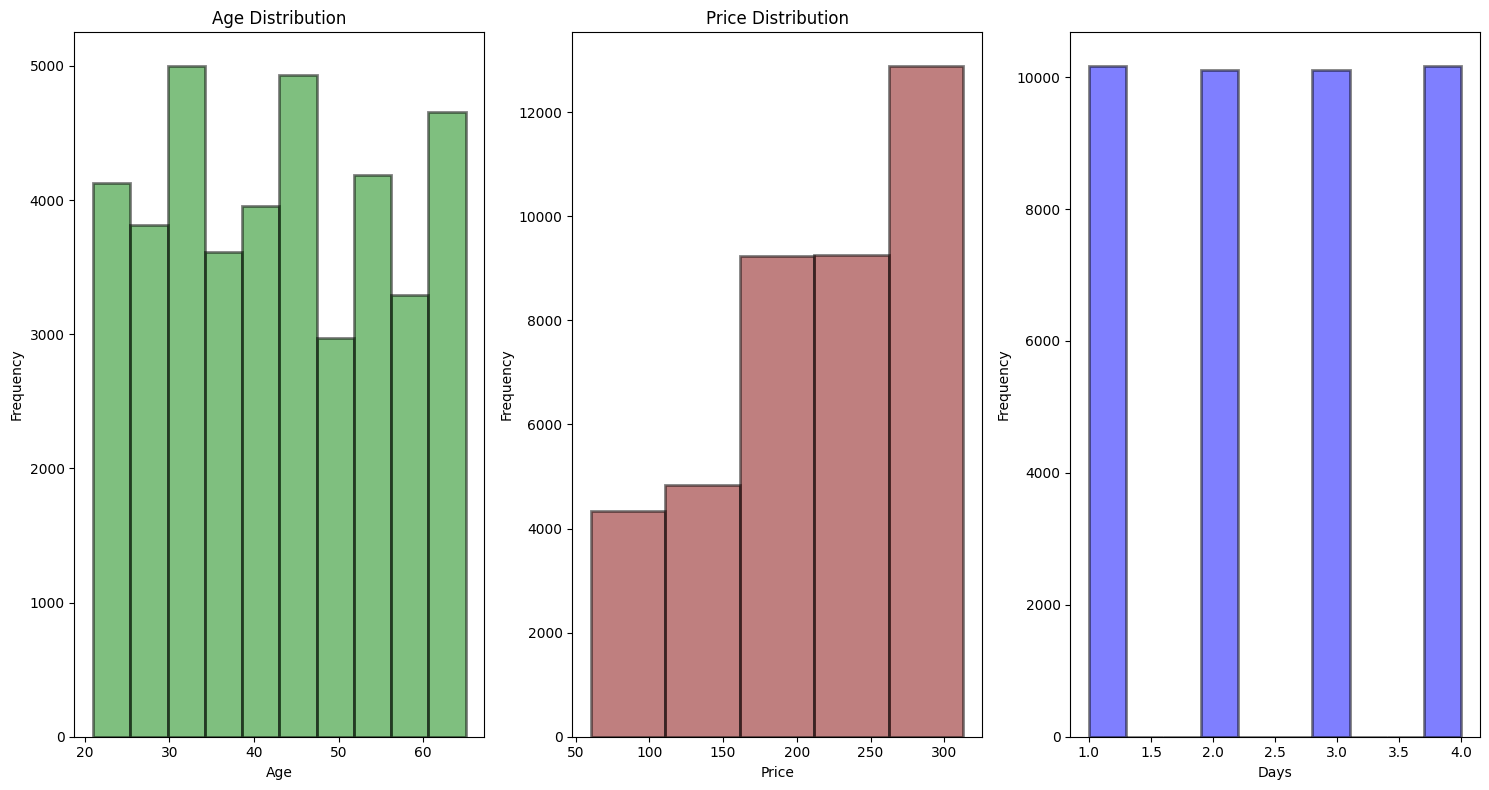

In [30]:
# Chart - 1 visualization code

fig, axs = plt.subplots(1, 3, figsize = (15,8))

# subplot 1
axs[0].hist(df['age'], bins=10, alpha=0.5, edgecolor='black', linewidth=2, label='Age', color='green')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Age Distribution')

# subplot 2
axs[1].hist(df['price'], bins=5, alpha=0.5, label='Price', edgecolor='black', linewidth=2, color='maroon')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Price Distribution')

# subplot 3
axs[2].hist(df['days'], bins=10, alpha=0.5, label='Days', edgecolor='black', linewidth=2, color='blue')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Insights:

1. Age is distributed uniformly between 22 and 65.

2. Price is unevenly distributed. There are lesser instances of inexpensive hotels (\$75 - \$175) being booked compared to expensive hotels (\$ 250 - \$350).

3. Number of days of stay is not a continous variable. The values are equally distributed among 1, 2, 3 and 4 days with about 10000 instances of each.

#### Chart - 2. What are the top 3 most popular hotels with most number of bookings? What are the top hotels with longest average duration of stay?

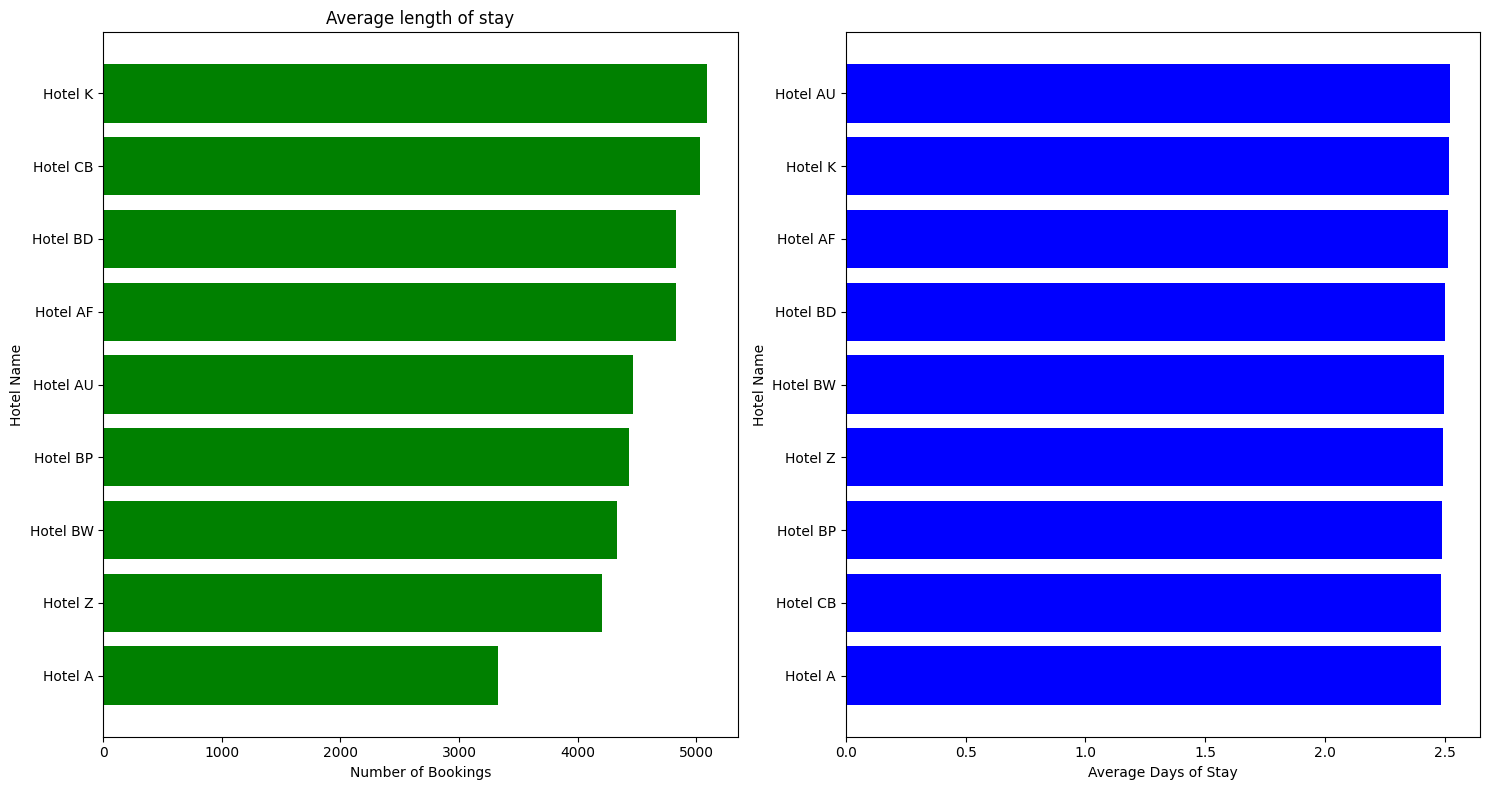

In [31]:
# creating subplots

fig, axs = plt.subplots(1, 2, figsize = (15,8))

# subplot 1

y = df.groupby(['hotelName'])['travelCode'].count().sort_values(ascending=True)
x = y.index
axs[0].barh(y=x, width=y, color='green')
axs[0].set_xlabel('Number of Bookings')
axs[0].set_ylabel('Hotel Name')
axs[0].set_title('Top 3 Hotels with Most Number of Bookings')

# subplot 2

y = df.groupby(['hotelName'])['days'].mean().sort_values(ascending=True)
x = y.index
axs[1].barh(y=x, width=y, color='blue')
axs[1].set_xlabel('Average Days of Stay')
axs[1].set_ylabel('Hotel Name')
axs[0].set_title('Average length of stay')

# Show plot
plt.tight_layout()
plt.show()

Insights:

1. Hotel K and Hotel CB are the most popular hotels with about 5000 bookings each. whereas hotel Z and hotel A lag behind with with about 4100 and 3300 bookings respectively.

2. There is no difference in the average length of stay amongst hotels. All hotels average a 2.5 days length of stay.

#### Chart - 3: Is there any discrepancy in hotels chosen by different genders?

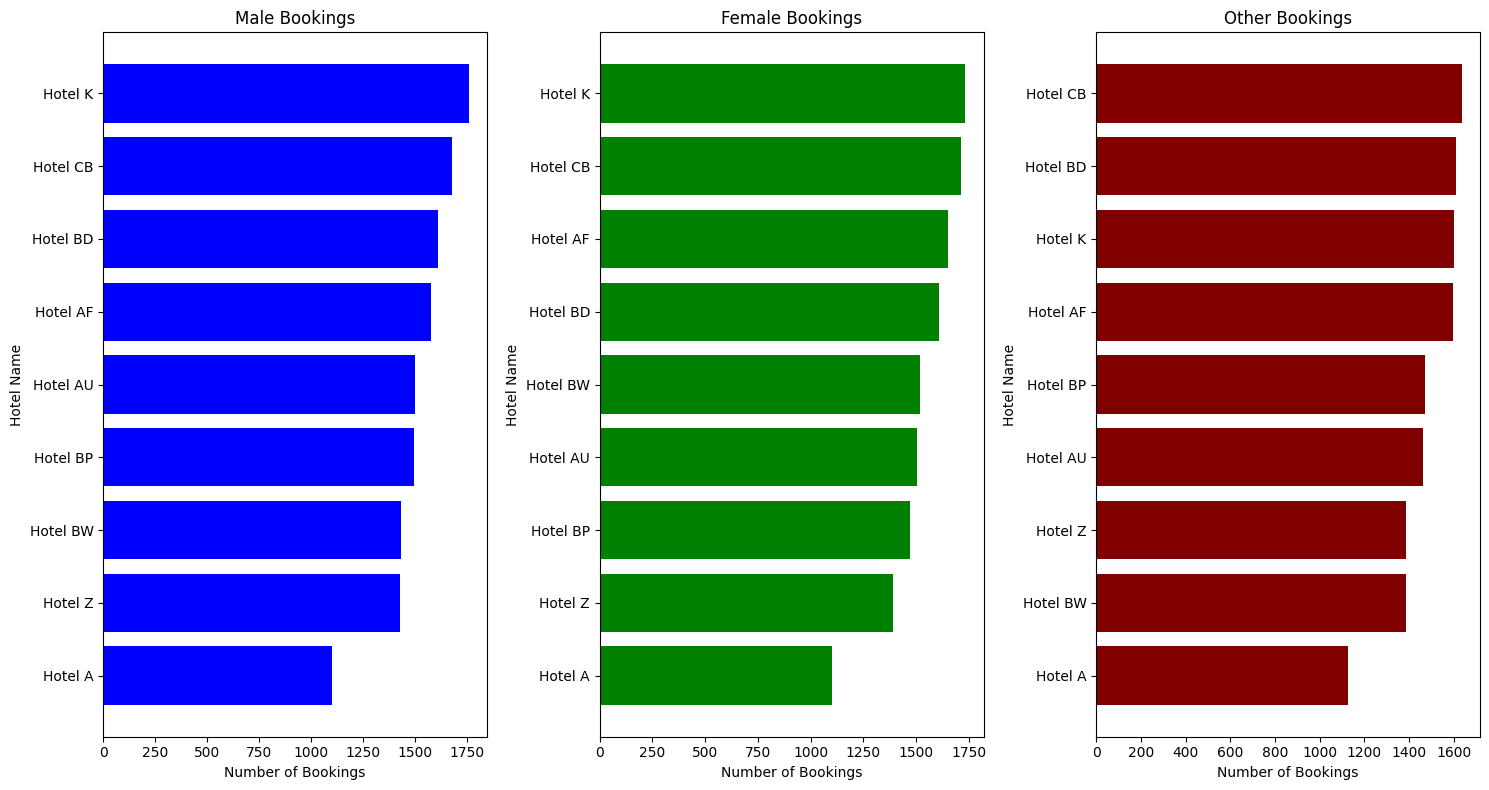

In [32]:
# Making the figure
fig, axs = plt.subplots(1, 3, figsize = (15,8))

# subplot 1
y = df.groupby(['hotelName', 'gender',])['travelCode'].count().unstack().reset_index().sort_values(by='male', ascending=True)
x = y['hotelName']
axs[0].barh(y=x, width=y['male'], color='blue', label='Male')
axs[0].set_xlabel('Number of Bookings')
axs[0].set_ylabel('Hotel Name')
axs[0].set_title('Male Bookings')

# subplot 2

y = df.groupby(['hotelName', 'gender',])['travelCode'].count().unstack().reset_index().sort_values(by='female', ascending=True)
x = y['hotelName']
axs[1].barh(y=x, width=y['female'], color='green', label='Female')
axs[1].set_xlabel('Number of Bookings')
axs[1].set_ylabel('Hotel Name')
axs[1].set_title('Female Bookings')

# subplot 3

y = df.groupby(['hotelName', 'gender',])['travelCode'].count().unstack().reset_index().sort_values(by='none', ascending=True)
x = y['hotelName']
axs[2].barh(y=x, width=y['none'], color='maroon', label='Other')
axs[2].set_xlabel('Number of Bookings')
axs[2].set_ylabel('Hotel Name')
axs[2].set_title('Other Bookings')

# Show plot
plt.tight_layout()
plt.show()

##### Insights:



1. While male and female users have hotel K and hotel CB as their top preferences and Hotel Z and hotel A as bottom, users identifying as 'none. prefer hotel CB and Hotel BD and have Hotel BW and hotel A as last preferences.

#### Chart - 4 What is the average price for each hotel?

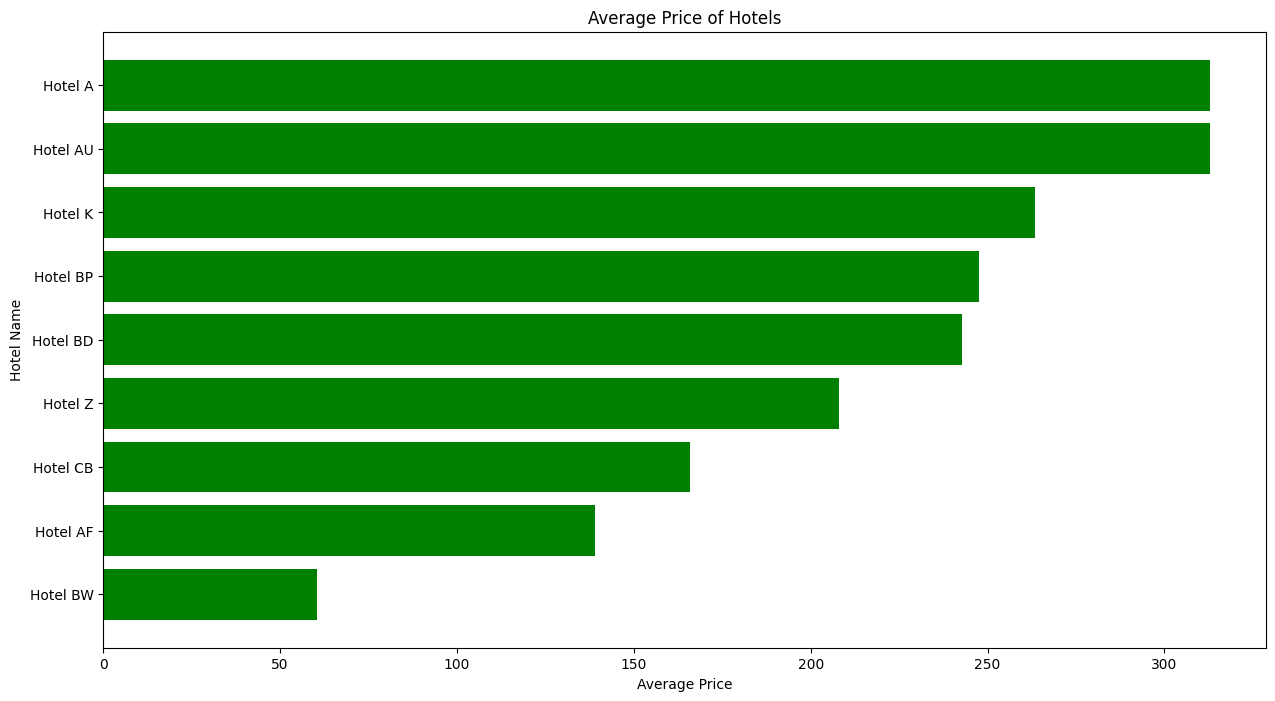

In [33]:
# Chart - 4 visualization code

plt.figure(figsize=(15,8))
y = df.groupby(['hotelName'])['price'].mean().sort_values(ascending=True)
x = y.index
plt.barh(y=x, width=y, color='green')
plt.xlabel('Average Price')
plt.ylabel('Hotel Name')
plt.title('Average Price of Hotels')
plt.show()


##### Insights:

1. Hotel A and hotel AU are the most expensive hotels with per night price of about 300 while hotel AF and Hotel BW are the most budget friendly with prices 140 and 60 respectively.

#### Chart - 5.   Do older people book more expensive hotels? What is the price preference based  on gender?

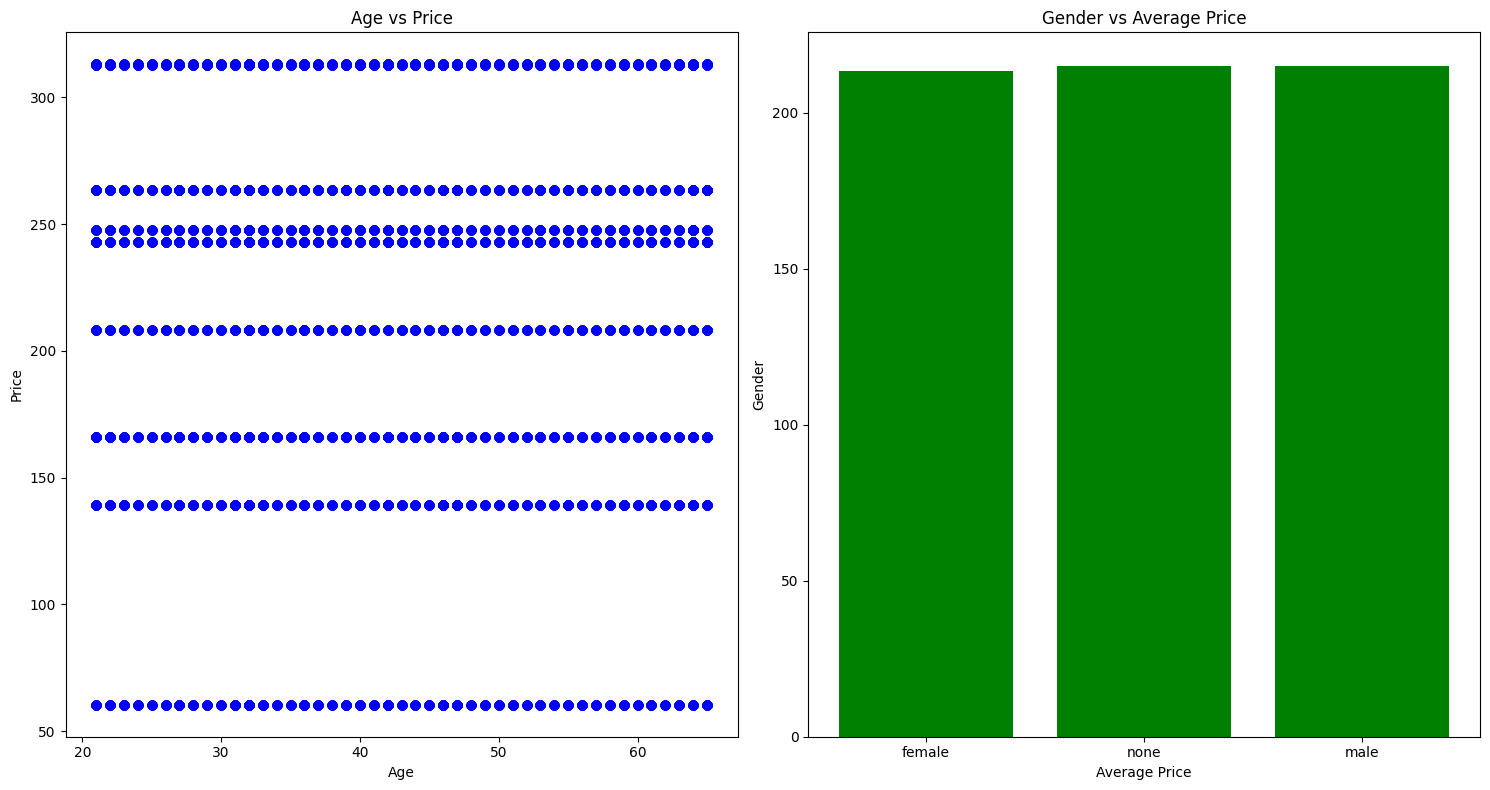

In [34]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize = (15,8))

# subplot 1
axs[0].scatter(df['age'], df['price'], color='blue')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Price')
axs[0].set_title('Age vs Price')

# subplot 2
y=df.groupby(['gender'])['price'].mean().sort_values(ascending=True)
x=y.index
axs[1].bar(x=x, height=y, color='green')
axs[1].set_xlabel('Average Price')
axs[1].set_ylabel('Gender')
axs[1].set_title('Gender vs Average Price')

plt.tight_layout()
plt.show()

Insights:

1. There is no correlation between age and price of hotel booked. Users of all ages book hotels of all prices with uniform frequency.

2. there isno gender disprity in prices of booked hotels. Users of all genders book hotels with average price of \$ 200.

## ***5. Feature engineering and data preprocessing***

***As we do not have hotel ratings data, we consider the number of days a user has stayed in a hotel as a measure of their preference.***

As hotel location is a non-negotiable, we do not include it in the user features.(In case very high similarities between other features may skew the similarity score and lead to recommendation of a hotel not in required destination).

Instead, we select the top hotel located in the given destination from the list of recommended hotels.

#### Creating user-hotel matrix

In [35]:
# create user-hotel matrix
user_hotel_matrix = df.groupby(['userCode','hotelName'])['days'].sum().unstack()

In [36]:
user_hotel_matrix

hotelName,Hotel A,Hotel AF,Hotel AU,Hotel BD,Hotel BP,Hotel BW,Hotel CB,Hotel K,Hotel Z
userCode,,,,,,,,,
0,7.0,11.0,5.0,9.0,4.0,5.0,1.0,19.0,10.0
1,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,18.0,6.0,6.0,7.0,5.0,20.0,7.0,11.0,17.0
3,22.0,13.0,18.0,25.0,5.0,22.0,15.0,14.0,4.0
4,18.0,17.0,21.0,16.0,9.0,12.0,27.0,14.0,10.0
...,...,...,...,...,...,...,...,...,...
1335,NaN,12.0,22.0,13.0,14.0,16.0,28.0,20.0,20.0
1336,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1337,NaN,4.0,10.0,6.0,1.0,3.0,NaN,5.0,2.0


In [37]:
# Fill the nan values of #days to 0
user_hotel_matrix.fillna(0, inplace=True)

#### Creating user features matrix

In [38]:
# Encoding gender of a user
cat_encoder = OrdinalEncoder()
cat_encoder.fit_transform(df[['gender']])
df['encoded_gender'] = cat_encoder.transform(df[['gender']])

In [39]:
# Encoding prices using price_quartiles
df['price_quartile'] = pd.qcut(df['price'], q=4, labels=False)

In [40]:
df['price_quartile']

,price_quartile
0,3
1,2
2,2
3,2
4,3
...,...
40547,2
40548,2
40549,0
40550,0


In [41]:
# Selecting relavant user features
user_features = ['age', 'encoded_gender', 'price_quartile']
df_user_features = df[user_features]

In [42]:
# Create user_feature group by usercode and find average of days and price_quartile
user_feature_matrix = df.groupby('userCode').agg({'price_quartile': 'mean','age': 'first', 'encoded_gender':'first'}).reset_index('userCode')

In [43]:
user_features = user_feature_matrix.set_index('userCode')

In [44]:
user_feature_matrix

,userCode,price_quartile,age,encoded_gender
0,0,1.407407,21,1.0
1,1,1.000000,37,1.0
2,2,1.361111,48,0.0
3,3,1.333333,23,0.0
4,4,1.267857,44,0.0
...,...,...,...,...
1305,1335,0.983333,23,1.0
1306,1336,2.000000,40,0.0
1307,1337,1.636364,28,1.0
1308,1338,2.000000,52,0.0


#### Creating hotel location df

In [45]:
hotel_locations = df[['hotelName','place']]

## ***6. Recommend hotels based on user similarity and destination***

In [46]:
def recommend_hotels(destination, target_user, user_hotel_matrix, user_feature_matrix, hotel_locations):


  # Calculating similarity score of target users with users in the database
  user_similarity_matrix = cosine_similarity(target_user, user_features)

  # finding indices of most similar users (highest cosine similarity score)
  indices = np.argsort(user_similarity_matrix[0])[::-1]

  # calculating weighted recommendation scores of hotels based on preferencs of the top similar users
  weighted_scores = sum([user_hotel_matrix.loc[indices[i]] * (1 - 0.1 * i) for i in range(10)]).sort_values(ascending=False)
  recos = weighted_scores.index.to_list()
  print(f'Top hotels for you with scores:{weighted_scores}')

  # select the top hotel in required location from the recommended hotel list
  i = 0
  print(f'You have enterd destination as {destination}')
  while i < len(recos):
      hotel_location = hotel_locations[hotel_locations['hotelName']==recos[i]]['place'].unique()

      # Check if the current hotel's rating is higher than the best found so far
      if destination in hotel_location:
       best_hotel = recos[i]
       print(f'We recommend {best_hotel} at {hotel_location} for you.' )

       break

      i += 1  # Move to the next recommended hotel



### Recommend hotels for an example user

In [47]:
Q1, Q2, Q3 = df['price'].quantile([0.25, 0.5, 0.75])
print(Q1, Q2, Q3)

165.99 242.88 263.41


In [48]:
# prepare data

def prepare_data( age, price, gender, cat_encoder):

  # encode gender
  df_temp = pd.DataFrame({'gender': [gender]})
  encoded_gender = cat_encoder.transform(df_temp).reshape(-1, 1)

  # encode price
  Q1, Q2, Q3 = 165.99, 242.88, 263.41

  if price <= Q1:
        price_quartile =  1
  elif price <= Q2:
        price_quartile =  2
  elif price <= Q3:
        price_quartile=  3
  else:
        price_quartile =  4


  target_user= [age, encoded_gender.item(), price_quartile]
  reshaped_target_user = np.array(target_user).reshape(1, -1)

  return reshaped_target_user


In [49]:
# Example user details

destination = 'Salvador (BH)'
age =33
gender = 'male'
price =170


In [50]:
# prepare data
target_user = prepare_data( age, price, gender, cat_encoder)

In [51]:
# recommend hotels
hotel = recommend_hotels(destination, target_user, user_hotel_matrix, user_feature_matrix, hotel_locations)

Top hotels for you with scores:hotelName
Hotel BW    49.4
Hotel A     44.8
Hotel CB    43.9
Hotel K     42.1
Hotel AF    37.0
Hotel AU    36.1
Hotel BP    33.5
Hotel BD    29.1
Hotel Z     23.6
dtype: float64
You have enterd destination as Salvador (BH)
We recommend Hotel K at ['Salvador (BH)'] for you.


# **Conclusion**

We have successfully built a recommendation system for providing hotel recommendations based on user features like age, gender and price sensitivity.

We have used collaborative filtering method to make the recommendations.

A user-hotel matrix was created which recorded each users rating of each otel.

A user features matrix recorded the relavant features of users like age, gender and price sensitivity.

The target user's similarity score with given users in the dataset was first calculated and the hotels were scored using weighted references of the most similar users.

Finally, the hotel with highest score which is located in the desired location is recommended to the user.